# JAX transforms of a TORAX simulation

As the TORAX simulation is entirely written in JAX, we can make use of powerful JAX transformations. In this notebook we will try out `jax.vmap` for batching simulations and `jax.grad` for taking gradients of simulation outputs with respect to inputs.

In [ ]:
#@title LICENSE
# Copyright 2025 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title Install TORAX

# Install the current version, as experimental features not yet on PyPI.
%pip install git+https://github.com/google-deepmind/torax.git

# Imports

In [ ]:
from torax.examples import iterhybrid_rampup
import torax
from torax import experimental
from torax.experimental import geometry
import jax
from jax import numpy as jnp
import matplotlib.pyplot as plt

## Loading ITER rampup case and running a simulation

First let's load the base config and prepare the objects needed to run the simulation.

In [ ]:
torax_config = torax.build_torax_config_from_file(iterhybrid_rampup.__file__)

In [ ]:
# We keep the `runtime_params_provider` as this is the object that we will override.
# We also take the `step_fn` which will be passed into the run loop.
step_fn = experimental.make_step_fn(torax_config)
runtime_params_provider = step_fn.runtime_params_provider

Also do a smoke check that the simulation runs:

In [ ]:
# The JITted run loop requires us to set a maximum number of time steps.
# This is necessary to enable reverse-mode auto-differentiation.
# See jax_utils.while_loop_bounded for more details.
max_steps = 100
output_states, output, final_i = experimental.run_loop_jit(step_fn, max_steps)

In [ ]:
# Do a quick check that the final iteration of the run loop is less than our
# max_steps. (Otherwise we will have missed some of the simulation.)
assert final_i < max_steps

Check what the configuration for Ip was for this simulation:

[ 0. 80.]
[ 3000000. 10500000.]


Text(0.5, 1.0, 'Trajectory for Ip in ITER rampup')

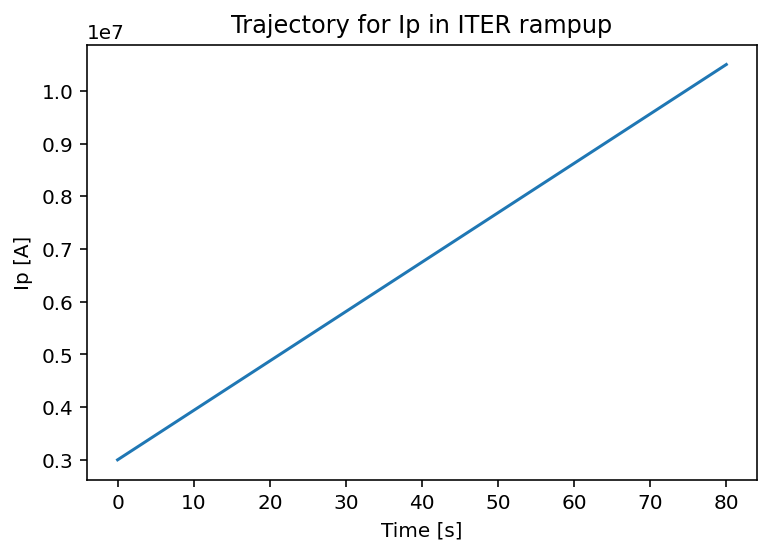

In [ ]:
print(runtime_params_provider.profile_conditions.Ip.time)
print(runtime_params_provider.profile_conditions.Ip.value)
plt.plot(runtime_params_provider.profile_conditions.Ip.time, runtime_params_provider.profile_conditions.Ip.value)
plt.xlabel('Time [s]')
plt.ylabel('Ip [A]')
plt.title('Trajectory for Ip in ITER rampup')

`Ip` was parameterised to linearly increase from 3MA to 10.5MA over 80s with two nodes (one at `t=0` and one at `t=80`)

We will now increase the resolution of the Ip parameterisation by 5x so it has ten nodes instead and look at applying various operations to the inner values (keeping the initial and final condition clamped).

In [ ]:
original_times = runtime_params_provider.profile_conditions.Ip.time
original_values = runtime_params_provider.profile_conditions.Ip.value
# Reparameterise, we will do various ops to the inner values.
time_ten_nodes = jnp.linspace(original_times[0], original_times[-1], 10)
Ip_ten_nodes = jnp.interp(time_ten_nodes, original_times, original_values)

## Using `jax.vmap` to investigate state sensitivity.

We will now run batched simulations with Ip clamped at the same initial and final condition and look at the effect on the ion temperature.

(Note:
We can use jax.vmap to automatically vectorize a function written for a single input so it can be applied efficiently across a whole batch of data.
This allows you to write simpler code without manually handling batch dimensions while achieving significantly faster performance than a standard Python loop, especially on hardware that makes use of SIMD (Single Instruction, Multiple Data) such as GPUs/TPUs and modern CPUs.)

In [ ]:
# Manually add some jitter to Ip
noise = jax.random.normal(jax.random.PRNGKey(0), shape=(8,)) * 5e5
Ip_ten_nodes_jitter = Ip_ten_nodes.at[1:-1].set(Ip_ten_nodes[1:-1]+noise)

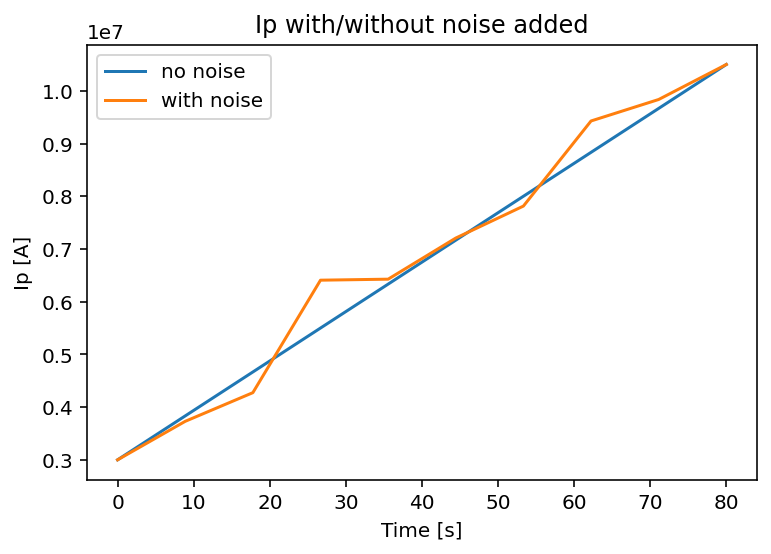

In [ ]:
plt.plot(time_ten_nodes, Ip_ten_nodes, label='no noise')
plt.plot(time_ten_nodes, Ip_ten_nodes_jitter, label='with noise')
plt.title('Ip with/without noise added')
plt.ylabel('Ip [A]')
plt.xlabel('Time [s]')
plt.legend()

Running a batched simulation over multiple noise vectors is very straightforward with `jax.vmap`.

We first define a function that will take in a RNG seed that will be used to add some jitter to the inner values of Ip.

In [ ]:
def run_simulation_Ip_with_noise(rng: jax.random.PRNGKey):
  noise = jax.random.normal(rng, shape=(8,)) * 5e5
  Ip_ten_nodes_jitter = Ip_ten_nodes.at[1:-1].set(Ip_ten_nodes[1:-1]+noise)
  Ip_overrides = experimental.TimeVaryingScalarUpdate(
      time=time_ten_nodes,
      value=Ip_ten_nodes_jitter,
  )
  runtime_overrides = runtime_params_provider.update_provider_from_mapping(
      {'profile_conditions.Ip': Ip_overrides}
  )
  output_states, _, final_i = experimental.run_loop_jit(
      step_fn, max_steps, runtime_overrides
  )
  return output_states.core_profiles.T_i.value, output_states.t, final_i

In [ ]:
T_i, t, final_i = run_simulation_Ip_with_noise(jax.random.PRNGKey(0))

In [ ]:
# Note the output always has the same shape equal to the max timesteps and we
# can filter out any dummy values.
print(T_i.shape)
T_i = T_i[:final_i+1, :]

(101, 25)


Running a batch of simulations is as simple as decorating the function with `jax.vmap`.

In [ ]:
@jax.jit
@jax.vmap
def run_simulation_Ip_with_noise_batched(rng: jax.random.PRNGKey):
  return run_simulation_Ip_with_noise(rng)

We now must make a batched rng vector. This is straightforward with the `jax.random.split` helper.

In [ ]:
batched_rng = jax.random.split(jax.random.PRNGKey(0), 5)

In [ ]:
T_i_batched, t_batched, final_i_batched = run_simulation_Ip_with_noise_batched(batched_rng)

In [ ]:
# Note the individual simulations may not run for the same number of iterations!
print(final_i_batched)

[41 40 40 40 40]


Let's now unpick the ion temperatures for each simulation at `t=40` (or as close to `t=40` as the simulation got).

In [ ]:
t_plot = 40

t_40_indices = []
for final_i, t_sim in zip(jnp.unstack(final_i_batched), jnp.unstack(t_batched)):
  t_40_indices.append(jnp.searchsorted(t_sim[:final_i+1], t_plot))

In [ ]:
T_i_40_profiles = []
for i, T_i_sim in enumerate(jnp.unstack(T_i_batched)):
  T_i_40_profiles.append(T_i_sim[t_40_indices[i]])

and plot the jittered and base profile

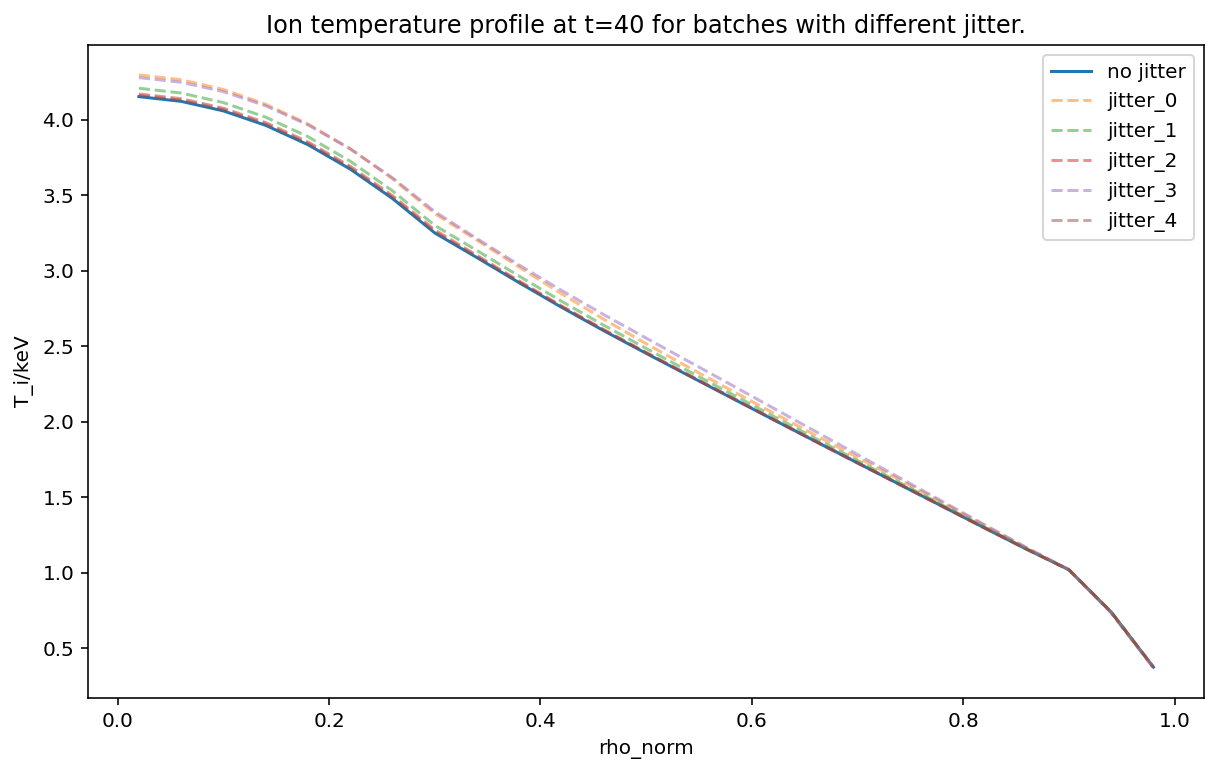

In [ ]:
grid = step_fn.geometry_provider.torax_mesh.cell_centers
plt.figure(figsize=(10, 6))
plt.plot(grid, output_states.core_profiles.T_i.value[20,:], label='no jitter')
for i, T_i_40_profile in enumerate(T_i_40_profiles):
  plt.plot(grid, T_i_40_profiles[i], label=f'jitter_{i}', linestyle='--', alpha=0.5)
plt.xlabel('rho_norm')
plt.ylabel('T_i/keV')
plt.title('Ion temperature profile at t=40 for batches with different jitter.')
plt.legend()

# Take gradients of a simulation

We will now define a reward function and optimise `Ip` to maximise the reward.

The reward is related to the volume average of the ratio between the magnetic shear and q-profile, known to correlate with increased confinement in ITG dominated plasmas. See: https://iopscience.iop.org/article/10.1088/0741-3335/56/12/125008.

In [ ]:
def calculate_rampup_cost(q_face, s_face, rho_face_norm, vpr_face):
  """Calculates reward to be maximised.

  Eq (2) in https://iopscience.iop.org/article/10.1088/0741-3335/56/12/125008.

  Args:
    q_face: The safety factor profile at the final time step.
    s_face: The magnetic shear profile at the final time step.
    rho_face_norm: The rho grid face centers
    vpr_face: dV/drho_norm on face grid.

  Returns:
    The scalar ramp-up cost J_sq.
  """
  s_over_q_face = s_face / (q_face + 1e-8)
  integrand = vpr_face * s_over_q_face
  volume_averaged_sq = jax.scipy.integrate.trapezoid(integrand, rho_face_norm)
  return volume_averaged_sq

In [ ]:
def reward_for_Ip(
    Ip_inner: jax.Array, geo_provider: geometry.StandardGeometryProvider
) -> jax.Array:
  Ip_ten_nodes_override = Ip_ten_nodes.at[1:-1].set(Ip_inner)
  Ip_overrides = experimental.TimeVaryingScalarUpdate(
      time=time_ten_nodes,
      value=Ip_ten_nodes_override,
  )
  runtime_overrides = runtime_params_provider.update_provider_from_mapping(
      {'profile_conditions.Ip': Ip_overrides}
  )
  output_states, _, final_i = experimental.run_loop_jit(
      step_fn, max_steps, runtime_overrides
  )
  final_s_face = output_states.core_profiles.s_face[final_i]
  final_q_face = output_states.core_profiles.q_face[final_i]
  final_t = output_states.t[final_i]
  geo_final_t = geo_provider(final_t)
  rho_face_norm = geo_final_t.rho_face_norm
  vpr_face = geo_final_t.vpr_face
  reward = calculate_rampup_cost(
      final_q_face, final_s_face, rho_face_norm, vpr_face
  )
  return reward

Let's now pull out those inner `Ip` values for our base case and calculate the reward.

In [ ]:
Ip_inner = Ip_ten_nodes[1:-1]

In [ ]:
rampup_reward = reward_for_Ip(Ip_inner, step_fn.geometry_provider)
print(rampup_reward)

318.74452467780026


With all of these defined it's now very straightforward to calculate gradients w.r.t our given `Ip` trajectory values.

Using `jax.grad` we can transform our forward function to a new function (with the same arguments) that computes the gradient.

(Note, a gradient graph usually takes about 2-3x (at worst 5x!) the runtime of the forward graph so is a little slower here but still pretty zippy.)

In [ ]:
# It's usually good practice to place `jax.jit` on top of other JAX
# transformations for good runtime performance.
@jax.jit
@jax.grad
def gradient_of_Ip(Ip_inner, geo_provider):
  return reward_for_Ip(Ip_inner, geo_provider)

gradient_of_Ip(Ip_inner, step_fn.geometry_provider)

Array([3.22953718e-06, 3.57099429e-06, 4.02918070e-06, 4.51583353e-06,
       3.10562597e-06, 1.61381592e-05, 1.01500867e-05, 1.22319465e-05],      dtype=float64)

We can also use gradient-descent to move towards a `Ip` trajectory that gives us a higher reward!

This is a very barebones implementation as a demonstration. In practice we should at least standardise our inputs and use JAX for the whole loop but there are a whole host of powerful optimisation libraries in the JAX ecosystem that are worth checking out to help, for example https://optax.readthedocs.io/en/latest/getting_started.html.

In [ ]:
learning_rate = 1e10
num_loops = 20
Ip_trajectory = Ip_inner
for _ in range(num_loops):
  grads = gradient_of_Ip(Ip_trajectory, step_fn.geometry_provider)
  # positive as we do gradient ascent here!
  Ip_trajectory += grads * learning_rate

final_reward = reward_for_Ip(Ip_trajectory, step_fn.geometry_provider)

In [ ]:
print(f'Initial reward: {rampup_reward}, new reward: {final_reward}')

Initial reward: 318.74452467780026, new reward: 392.48055410042844


The solution in this demo just increases the current (since that increases `s/q`). A more complete application should also set a constraint on minimum `q`, which is out of the scope of this demo.

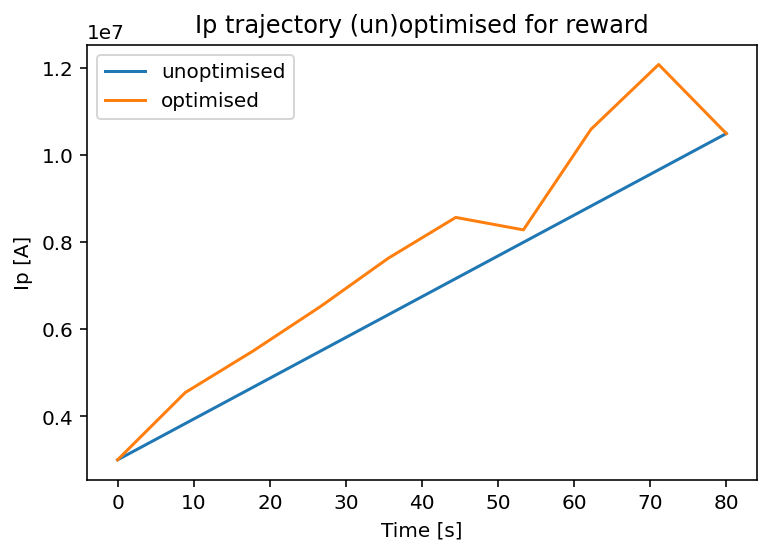

In [ ]:
Ip_optimised = Ip_ten_nodes.at[1:-1].set(Ip_trajectory)
plt.plot(time_ten_nodes, Ip_ten_nodes, label='unoptimised')
plt.plot(time_ten_nodes, Ip_optimised, label='optimised')
plt.title('Ip trajectory (un)optimised for reward')
plt.ylabel('Ip [A]')
plt.xlabel('Time [s]')
plt.legend()